In [2]:
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid

from torch.utils.data.dataloader import DataLoader

In [3]:
train_data = "./data/cropped/train"
val_data = "./data/cropped/val"
test_data = "./data/cropped/test"


train_dataset = ImageFolder(train_data,transform = transforms.Compose([
    transforms.Resize((150, 150)),transforms.ToTensor()
]))
val_dataset = ImageFolder(val_data,transform = transforms.Compose([
    transforms.Resize((150, 150)),transforms.ToTensor()
]))
test_dataset = ImageFolder(test_data,transforms.Compose([
    transforms.Resize((150, 150)),transforms.ToTensor()
]))

In [4]:
img, label = train_dataset[0]
print(img.shape,label)

torch.Size([3, 150, 150]) 0


In [5]:
print("Follwing classes are there : \n", train_dataset.classes)

Follwing classes are there : 
 ['Closed', 'Open', 'Semi']


Label : Closed


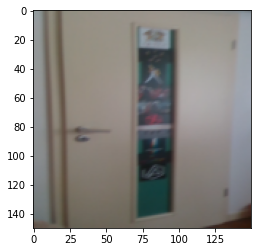

In [6]:
def display_img(img,label):
    print(f"Label : {train_dataset.classes[label]}")
    plt.imshow(img.permute(1,2,0))

#display the first image in the dataset
display_img(*train_dataset[2])

In [7]:
batch_size = 128

train_dl = DataLoader(train_dataset, batch_size, shuffle = True, num_workers = 4, pin_memory = True)
val_dl = DataLoader(val_dataset, batch_size*2, num_workers = 4, pin_memory = True)

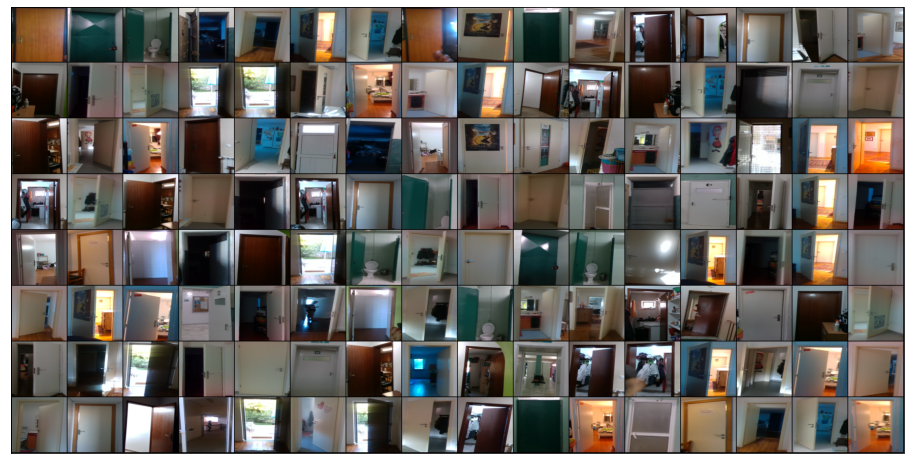

In [8]:
def show_batch(dl):
    """Plot images grid of single batch"""
    for images, _ in dl:
        fig, ax = plt.subplots(figsize = (16,12))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1,2,0))
        break
        
show_batch(train_dl)

In [9]:
class ImageClassificationBase(nn.Module):
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    

    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    

    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
            

In [10]:
class DoorClassification(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Flatten(),
            nn.Linear(82944, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 3))
    

    def forward(self, xb):
        return self.network(xb)

In [11]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

  
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

  
def fit(epochs, lr, model, train_loader, val_loader, opt_func = torch.optim.SGD):
    
    history = []
    optimizer = opt_func(model.parameters(),lr)
    for epoch in range(epochs):
        
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    
    return history

In [13]:
num_epochs = 25
opt_func = torch.optim.Adam
lr = 0.0005

model = DoorClassification()

#fitting the model on training data and record the result after each epoch
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 1.1137, val_loss: 1.1016, val_acc: 0.3333
Epoch [1], train_loss: 1.1059, val_loss: 1.0971, val_acc: 0.3333
Epoch [2], train_loss: 1.0954, val_loss: 1.0801, val_acc: 0.3333
Epoch [3], train_loss: 1.0813, val_loss: 1.0432, val_acc: 0.4833
Epoch [4], train_loss: 1.0387, val_loss: 0.9248, val_acc: 0.5667
Epoch [5], train_loss: 1.0205, val_loss: 0.9153, val_acc: 0.5500
Epoch [6], train_loss: 0.9660, val_loss: 0.8861, val_acc: 0.4667
Epoch [7], train_loss: 0.9110, val_loss: 0.8466, val_acc: 0.5167
Epoch [8], train_loss: 0.8335, val_loss: 0.7583, val_acc: 0.5833
Epoch [9], train_loss: 0.7663, val_loss: 0.8207, val_acc: 0.6000
Epoch [10], train_loss: 0.8230, val_loss: 0.7233, val_acc: 0.6667
Epoch [11], train_loss: 0.7126, val_loss: 0.6850, val_acc: 0.6833
Epoch [12], train_loss: 0.6187, val_loss: 0.6521, val_acc: 0.6833
Epoch [13], train_loss: 0.5262, val_loss: 0.7523, val_acc: 0.7167
Epoch [14], train_loss: 0.6201, val_loss: 0.5514, val_acc: 0.7333
Epoch [15], train_lo

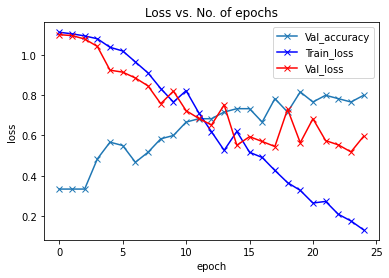

In [14]:
def plot_accuracies(history):
    """ Plot the history of accuracies"""
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');
    

plot_accuracies(history)

def plot_losses(history):
    """ Plot the losses in each epoch"""
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(["Val_accuracy", "Train_loss", "Val_loss"])
    plt.title('Loss vs. No. of epochs');

plot_losses(history)

In [15]:
accuracies = [x['val_acc'] for x in history]
torch.save(model.state_dict(), f"models/model_epoch{num_epochs}_val_acc{accuracies[-1]:.2f}.pt")

In [6]:
from pathlib import Path
from model import DoorClassification

CLASSIFICATION_MODEL = Path("models/model_classification.pt")
pytorch_model = DoorClassification()
pytorch_model.load_state_dict(torch.load(CLASSIFICATION_MODEL))
pytorch_model.eval()

DoorClassification(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=82944, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in_

<AxesSubplot:>

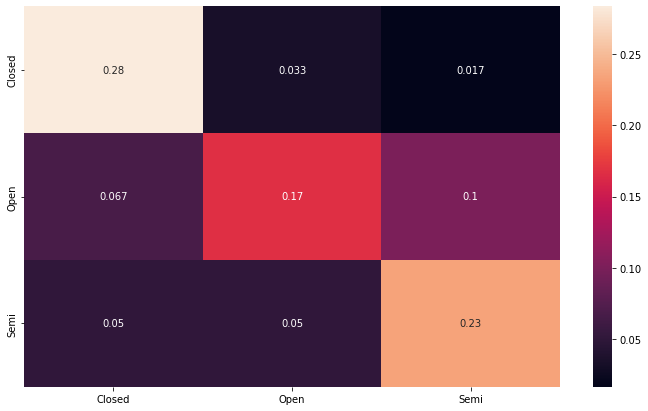

In [26]:
test_dl = DataLoader(test_dataset, 128, num_workers = 4, pin_memory = True)
# input_batch = next(iter(test_dl))
# preds = []

# pytorch_model.eval()
# with torch.no_grad():
#     for i in range(len(input_batch[0])):
#         sample, label = input_batch[0][i], input_batch[1][i]
#         output = pytorch_model(sample.unsqueeze(0))
#         preds.append((output.argmax(), label))

# print(preds)

y_pred = []
y_true = []

for inputs, labels in test_dl:
    output = pytorch_model(inputs)

    output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
    y_pred.extend(output)

    labels = labels.data.cpu().numpy()
    y_true.extend(labels)

classes = ("Closed", "Open", "Semi")

from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd 
import numpy as np

cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(
    cf_matrix/np.sum(cf_matrix), 
    index = [i for i in classes],
    columns= [i for i in classes]
)
plt.figure(figsize=(12,7))
sns.heatmap(df_cm, annot=True)

